In [1]:
import sys
sys.path.append('..')

# Model, data, trainer

In [106]:
import torch
import pytorch_lightning as pl
from ct.model.ct_apy import CT_aPY
from ct.data.apy import aPY

checkpoint_path = '../logs/ct_apy/2022-12-09_035640-bs=64,cmr=1.0,cnh=4,cnl=2,d=512,e=200,ec=2.0,lw=False,l=0.0001,nh=2,r=50,s=cosine_restart,we=20/checkpoint/epoch=193-step=17266.ckpt'

model = CT_aPY.load_from_checkpoint(checkpoint_path)
apy = aPY(batch_size=32, data_path='../data')
trainer = pl.Trainer(accelerator='gpu', devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [107]:
trainer.test(model=model, datamodule=apy)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 180/180 [01:03<00:00,  2.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8250824809074402
      test_cls_loss         1.4773677587509155
     test_expl_loss         0.09201298654079437
        test_loss           1.6613935232162476
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_cls_loss': 1.4773677587509155,
  'test_expl_loss': 0.09201298654079437,
  'test_acc': 0.8250824809074402,
  'test_loss': 1.6613935232162476}]

# Accuracy on aPY dataset computed from accuracy on aPascal dataset

In [61]:
import pandas as pd
from ct.data.apy import aPY

apy = aPY(batch_size=64, data_path='../data', yahoo=True)
apy.setup()
test = apy.test_dataloader()

# Delete samples with no attributes
apascal_train_df = pd.read_csv(
  '../data/apy/apascal_train.txt', sep=' ', header=None,
  names=['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax'] + list(range(64)))

attributes = apascal_train_df[range(64)].to_numpy()
apascal_train_df = apascal_train_df[attributes.sum(-1) != 0]

apascal_test_df = pd.read_csv(
  '../data/apy/apascal_test.txt', sep=' ', header=None,
  names=['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax'] + list(range(64)))

attributes = apascal_test_df[range(64)].to_numpy()
apascal_test_df = apascal_test_df[attributes.sum(-1) != 0]

ayahoo_test_df = pd.read_csv(
  '../data/apy/ayahoo_test.txt', sep=' ', header=None,
  names=['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax'] + list(range(64)))

attributes = ayahoo_test_df[range(64)].to_numpy()
ayahoo_test_df = ayahoo_test_df[attributes.sum(-1) != 0]

print('#train samples: ', len(apascal_train_df))
print('#test pascal samples: ', len(apascal_test_df))
print('#test yahoo samples: ', len(ayahoo_test_df))
print('#samples total: ', len(apascal_train_df) + len(apascal_test_df) + len(ayahoo_test_df))
print('#test samples: ', len(apascal_test_df) + len(ayahoo_test_df))

#train samples:  6315
#test pascal samples:  5757
#test yahoo samples:  2278
#samples total:  14350
#test samples:  8035


In [62]:
acc_pascal = 0.858
acc_py = acc_pascal * len(apascal_test_df) / (len(apascal_test_df) + len(ayahoo_test_df))
print(acc_py)

0.6147487243310517


Authors report 85.8 % acc on pascal test data and 61.5 % acc on combined pascal and yahoo test data.

# Class predictions on aYahoo test dataset

Predict on Yahoo test dataset and visualize to which classes of Pascal does the model classifies. Compare model learned with $\lambda = 0.0$ and $\lambda > 0.0$ to see if there is any effect. We woul like to see fail-safe misclassification.

In [2]:
import torch
import pytorch_lightning as pl
from ct.model.ct_apy import CT_aPY
from ct.data.apy import aPY

checkpoint_path = '../logs/ct_apy/2022-12-09_035640-bs=64,cmr=1.0,cnh=4,cnl=2,d=512,e=200,ec=2.0,lw=False,l=0.0001,nh=2,r=50,s=cosine_restart,we=20/checkpoint/epoch=193-step=17266.ckpt'

model = CT_aPY.load_from_checkpoint(checkpoint_path)
trainer = pl.Trainer(accelerator='gpu', devices=1)
apy = aPY(batch_size=16, data_path='../data', yahoo=True)
apy.setup()
test = iter(apy.test_dataloader())

id2class = apy.train.dataset.id2class
id2attribute = apy.train.dataset.id2attribute

/opt/conda/envs/dd2412/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Predictions on individual images

In [3]:
batch = next(test)

pred_out = model.my_predict_step(batch)
image, target_class, target_concept, pred_class, attn = pred_out

target class:  monkey
predicted class:  person
target concepts:  ['Tail' 'Head' 'Ear' 'Nose' 'Mouth' 'Hair' 'Face' 'Eye' 'Torso' 'Hand'
 'Arm' 'Leg' 'Foot/Shoe' 'Skin' 'Furry']
predicted concepts:  ['Head' 'Ear' 'Nose' 'Mouth' 'Face' 'Eye' 'Torso' 'Hand' 'Arm' 'Leg'
 'Skin' 'Cloth']


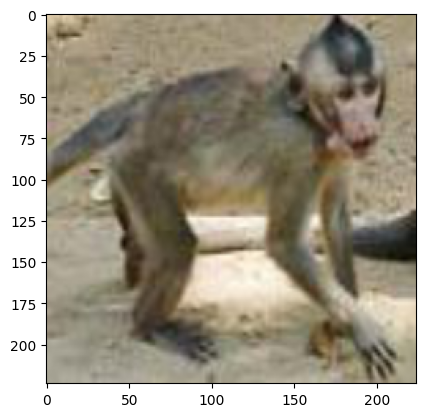

In [4]:
import matplotlib.pyplot as plt

c_th = 1/20

idx = 6
plt.imshow(image[idx].permute(1, 2, 0))
print('target class: ', id2class[target_class[idx]])
print('predicted class: ', id2class[pred_class[idx]])
print('target concepts: ', id2attribute[target_concept[idx] == 1])
print('predicted concepts: ', id2attribute[attn[idx] > c_th])

## Predict whole yahoo dataset

In [4]:
pred_out = trainer.predict(model=model, dataloaders=apy.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/dd2412/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 143/143 [00:33<00:00,  4.23it/s]


In [5]:
import numpy as np

n_yahoo_classes = 12
n_pascal_classes = 20

pred_mat = np.zeros((n_yahoo_classes, n_pascal_classes))

for pred_batch in pred_out:
  target_class, _, pred_class, _ = pred_batch
  pred_mat[target_class-n_pascal_classes, pred_class] += 1

# Normalize to sum to 1 for each class from Yahoo test set
pred_mat = pred_mat / pred_mat.sum(axis=1)[..., None]

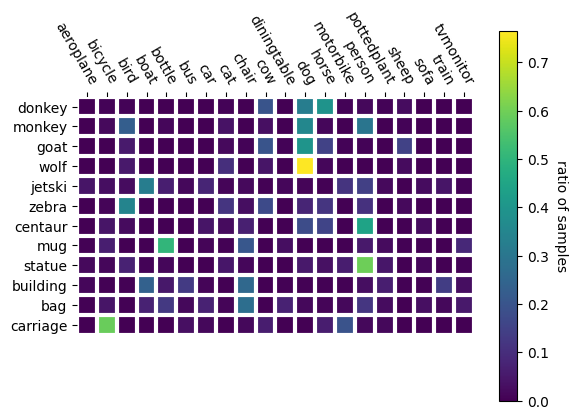

In [7]:
import matplotlib.pyplot as plt
from plot import heatmap

fig, ax = plt.subplots()
im, cbar = heatmap(pred_mat, id2class[20:], id2class[:20], ax=ax,
                   cmap="viridis", cbarlabel="ratio of samples")


# Attribute predictions on aYahoo test dataset

Predict attn on over attributes on aYahoo test data. Pick k attributes with highest attention and measure if they all correspond to ground truth attributes. Report ratio of samples with attributes correctly classified in this way.

We are again interested how the situation differs if we use various values for explanation coefficient.

In [165]:
import numpy as np

def attribute_topk_acc(pred_out, k):
  correctly_predicted_samples = 0
  total_samples = 0

  for pred_batch in pred_out:
    _, target_concept, _, attn = pred_batch
    
    batch_size = target_concept.shape[0]

    ind1 = torch.tensor(range(batch_size)).repeat_interleave(k).reshape(batch_size, k)
    ind2 = attn.topk(k).indices
    correctly_predicted_attributes = target_concept[ind1, ind2]

    k_vec = torch.tensor([k]*batch_size)[None, ...]
    n_concepts_in_sample = target_concept.sum(-1)[None, ...]
    comp = torch.cat([k_vec, n_concepts_in_sample]).min(0).values

    correctly_predicted_samples += (correctly_predicted_attributes.sum(-1) == comp).sum()
    total_samples += batch_size

  ratio_correctly_predicted = correctly_predicted_samples / total_samples

  return ratio_correctly_predicted

In [169]:
import torch
import pytorch_lightning as pl
from ct.model.ct_apy import CT_aPY
from ct.data.apy import aPY

checkpoint_path = '../logs/ct_apy/2022-12-09_035640-bs=64,cmr=1.0,cnh=4,cnl=2,d=512,e=200,ec=2.0,lw=False,l=0.0001,nh=2,r=50,s=cosine_restart,we=20/checkpoint/epoch=193-step=17266.ckpt'

model = CT_aPY.load_from_checkpoint(checkpoint_path)
trainer = pl.Trainer(accelerator='gpu', devices=1)

apy = aPY(batch_size=64, data_path='../data', yahoo=False)
apy.setup()
test_apascal = apy.test_dataloader()

apy = aPY(batch_size=64, data_path='../data', yahoo=True)
apy.setup()
test_ayahoo = apy.test_dataloader()

id2class = apy.train.dataset.id2class
id2attribute = apy.train.dataset.id2attribute

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [167]:
pred_out = trainer.predict(model=model, dataloaders=test_apascal)
print('k=1: ', attribute_topk_acc(pred_out, 1))
print('k=2: ', attribute_topk_acc(pred_out, 2))
print('k=3: ', attribute_topk_acc(pred_out, 3))
print('k=4: ', attribute_topk_acc(pred_out, 4))
print('k=5: ', attribute_topk_acc(pred_out, 5))
print('k=6: ', attribute_topk_acc(pred_out, 6))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/dd2412/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 90/90 [00:58<00:00,  1.53it/s]
k=1:  tensor(0.8216)
k=2:  tensor(0.6950)
k=3:  tensor(0.5864)
k=4:  tensor(0.4977)
k=5:  tensor(0.4393)
k=6:  tensor(0.4117)


In [170]:
pred_out = trainer.predict(model=model, dataloaders=test_ayahoo)
print('k=1: ', attribute_topk_acc(pred_out, 1))
print('k=2: ', attribute_topk_acc(pred_out, 2))
print('k=3: ', attribute_topk_acc(pred_out, 3))
print('k=4: ', attribute_topk_acc(pred_out, 4))
print('k=5: ', attribute_topk_acc(pred_out, 5))
print('k=6: ', attribute_topk_acc(pred_out, 6))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/dd2412/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 36/36 [00:28<00:00,  1.26it/s]
k=1:  tensor(0.5657)
k=2:  tensor(0.3759)
k=3:  tensor(0.2714)
k=4:  tensor(0.2025)
k=5:  tensor(0.1550)
k=6:  tensor(0.1304)
